In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

model_path = '/content/gdrive/MyDrive/vae_200ep.model'

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np


import torchvision.datasets as datasets
import torchvision.transforms as transforms


%matplotlib inline

In [ ]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

In [ ]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(cv2.cvtColor(imgs, cv2.COLOR_RGB2BGR))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
!git clone https://github.com/Sitnich/ssyp-2022-materials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/ssyp-2022-materials/data/pokemon.zip -d /content/drive/MyDrive/pokemon

In [ ]:
dataset = datasets.ImageFolder("/content/drive/MyDrive/pokemon/", transforms.Compose([
            transforms.Resize(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.RandomRotation((90,90)),
            transforms.Normalize((.5,.5,.5),(.5,.5,.5))
            ]))

In [ ]:
epochs = 200
batch_size = 512

In [ ]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
visualise(torch.cat([dataset[i][0].unsqueeze(0) for i in [3, 15, 182, 592, 394, 57]], dim=0))

Вглядимся в модель вариационного автокодировщика. В отличии от GAN, в котором генератор пытается обмануть дискриминатор, а дискриминатор старается не быть обманутым, VAE решает задачу реконструкции элемента множества X в латентном пространстве. 

Полностью архитектура выглядит так:


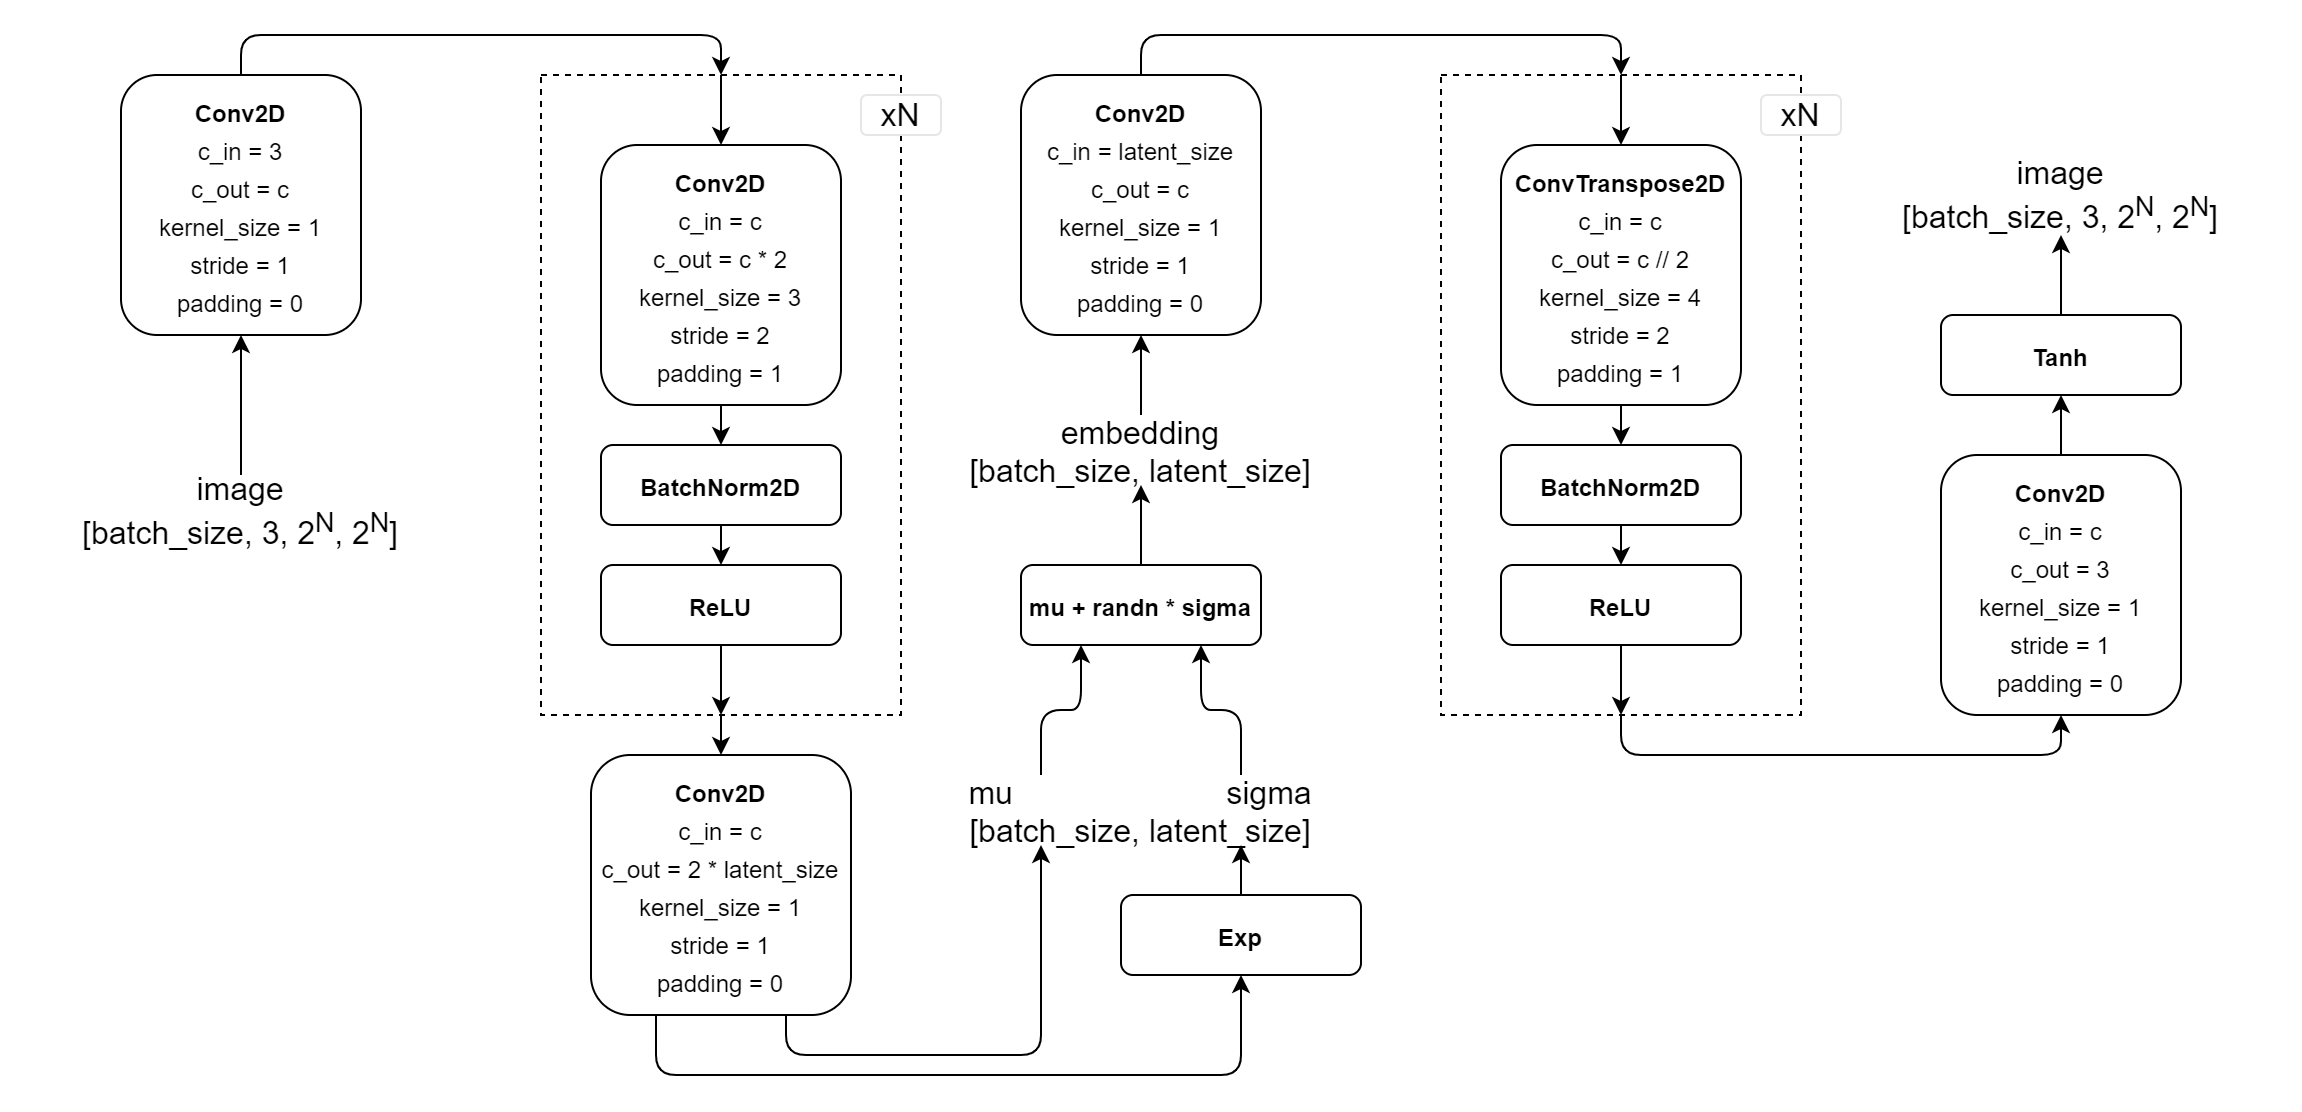

![](imgs/VAE.png)Из нее можно выделить две части: Encoder (по изображению возвращает mu и sigma) и Decoder (по случайному шуму восстанавливает изображение). На высоком уровне VAE можно представить так:

![](imgs/VAE_highlevel.png)

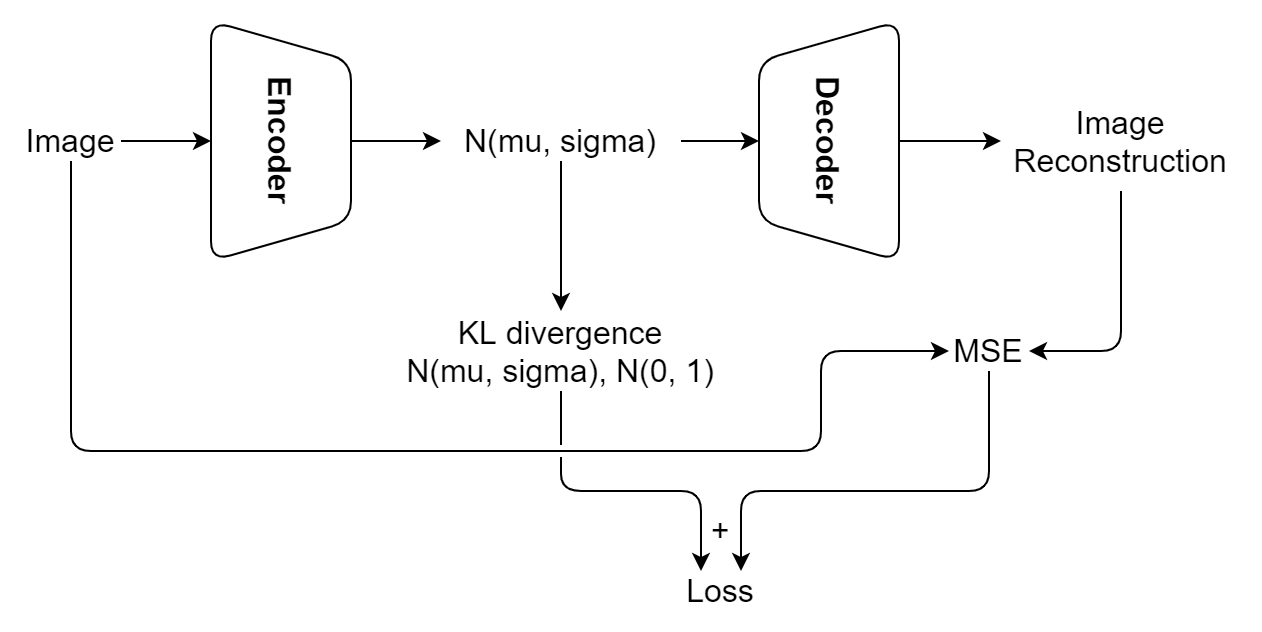


В данном задании вам необходимо реализовать полную архитектуру VAE.

#### Методы
* `__init__` - принимает на вход `img_size`, `downsamplings`, `latent_size`, `linear_hidden_size`, `down_channels` и `up_channels`. `img_size` - размер стороны входного изображения. `downsamplings` - количество downsampling (и upsampling) блоков. `latent_size` - размер латентного пространства, в котором в который будет закодирована картинка. `linear_hidden_size` количество нейронов на скрытом слое полносвязной сети в конце encoder'а. Для полносвязной сети decoder'а это число стоит умножить на 2. `down_channels` - количество каналов, в которое будет преобразовано трехцветное изображение перед применением `downsampling` блоков. `up_channels` - количество каналов, которое должно получиться после применения всех upsampling блоков.

* `forward` - принимает на вход `x`. Считает распределение $N(\mu, \sigma^2)$ и вектор $z \sim N(\mu, \sigma^2)$. Возвращает $x'$ - восстановленную из вектора $z$ картинку и $D_{KL}(N(\mu, \sigma^2), N(0, 1)) = 0.5 \cdot (\sigma^2 + \mu^2 - \log \sigma^2 - 1)$.

* `encode` - принимает на вход `x`. Возвращает вектор из распределения $N(\mu, \sigma^2)$.

* `decode` - принимает на вход `z`. Возвращает восстановленную по вектору картинку.


#### Если хочется улучшить качество
https://arxiv.org/pdf/1906.00446.pdf

In [ ]:
class VAE(nn.Module):
    def __init__(self, img_size=64, downsamplings=5, latent_size=512, linear_hidden_size=1024, down_channels=8, up_channels=16):
        super().__init__()
        downsamplings = int(np.log2(img_size))
        
        self.img_size = img_size
        self.downsamplings = downsamplings
        self.latent_size = latent_size
        self.linear_hidden_size = linear_hidden_size
        self.down_channels = down_channels
        self.up_channels = up_channels

        c = down_channels
        # и реализуйте слои кодировщика (энкодера)
        encoder_list = []
        encoder_list +=  nn.Sequential(
              nn.Conv2d(3, c, 1, 1, 0))
        for i in range(downsamplings):
            encoder_list += nn.Sequential(nn.Conv2d(c, c * 2, 3, 2, 1),
            nn.BatchNorm2d(c * 2),
            nn.ReLU())
            c *= 2
        encoder_list += nn.Sequential(
            nn.Conv2d(c, 2 * latent_size, 1, 1, 0))
        self.encoder = nn.Sequential(*encoder_list)
        c = up_channels * 2 ** down_channels
        decoder_list = []
        decoder_list += nn.Sequential(
            nn.Conv2d(latent_size, c, 1, 1, 0))
        for i in range(downsamplings):
            decoder_list += nn.Sequential(nn.ConvTranspose2d(c, c // 2, 4, 2, 1),
            nn.BatchNorm2d(c // 2),
            nn.ReLU())
            c = c // 2
        decoder_list += nn.Sequential(
            nn.Conv2d(c, 3, 1, 1, 0))
        self.decoder = nn.Sequential(*decoder_list)

    def forward(self, x):
        input = self.encoder(x)

        mu = input[:, :self.latent_size]
        sigma = torch.exp(input[:, self.latent_size:])

        eps = torch.randn_like(sigma)
        z = eps * sigma + mu

        x_pred = self.decoder(z)
        kld = 0.5 * (sigma ** 2 + mu ** 2 - torch.log(sigma ** 2) - 1)

        return x_pred, kld


    
    def encode(self, x):
        input = self.encoder(x)

        mu = input[:, :self.latent_size]
        sigma = torch.exp(input[:, self.latent_size:])

        eps = torch.randn_like(sigma)
        z = eps * sigma + mu

        return z
    
    def decode(self, z):
        return self.decoder(z)

In [ ]:
def train_vae():
    vae = VAE().to(device)
    vae_optim = Adam(vae.parameters(), lr=1e-4)
    vae.load_state_dict(torch.load(model_path, map_location = device)) 

    test_imgs_1 = torch.cat([dataset[i][0].unsqueeze(0) for i in (0, 34, 76, 230)])
    test_imgs_2 = torch.cat([dataset[i][0].unsqueeze(0) for i in (734, 123, 512, 478)])

    for ep in range(epochs):
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0

        if ep % 10 == 0:
            with torch.no_grad():
                z_1 = vae.encode(test_imgs_1.to(device))
                z_2 = vae.encode(test_imgs_2.to(device))
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, (batch, _) in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.cuda()
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()

        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")
        torch.save(vae.state_dict(), model_path)

train_vae()